# Moving to Berlin - A Neighbourhood Guide for Newcomers to Berlin

## IBM Applied Data Science Capstone Project

### Step 1 - Importing the Neighbourhood Data

#### Import necessary libraries

In [1]:
import pandas as pd
import html5lib
import numpy as np # library to handle data in a vectorized manner

# Install a conda package in the current Jupyter kernel
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.extra.rate_limiter import RateLimiter

import json
import requests # library to handle requests
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import os
from os import path
import matplotlib.cm as cm
import matplotlib.colors as colors

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Import the Berlin Neighbourhood names

In [2]:
berlin_df = pd.DataFrame(pd.read_csv('Berlin Neighbourhoods.csv'))

In [3]:
berlin_df.head()

Neighbourhood
0             Adlershof
1  Alt-Hohenschönhausen
2           Alt-Treptow
3          Altglienicke
4        Baumschulenweg

#### Check Number of Neighbourhoods Imported

In [4]:
berlin_df.count()

Neighbourhood    96
dtype: int64

### Step 2 - Add Latitude & Longitude coordinates into Berlin DataFrame

#### Add 'Berlin, DE' to Complete Address

This ensures that we use the correct Neighbourhood names to retrieve the Latitude and Longitude Coordinates.
<br>
<br>
i.e 'Schöneberg, Berlin' **NOT** 'Schöneberg, Brandenburg'

In [5]:
berlin_df['Location'] = berlin_df['Neighbourhood'].astype(str) + ', Berlin, DE'

In [6]:
berlin_df.head()

Neighbourhood                          Location
0             Adlershof             Adlershof, Berlin, DE
1  Alt-Hohenschönhausen  Alt-Hohenschönhausen, Berlin, DE
2           Alt-Treptow           Alt-Treptow, Berlin, DE
3          Altglienicke          Altglienicke, Berlin, DE
4        Baumschulenweg        Baumschulenweg, Berlin, DE

#### Add the Coordinates

In [7]:
locator = Nominatim(user_agent="myexplorer")
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
berlin_df['Full_Location'] = berlin_df['Location'].apply(geocode)
berlin_df['Coord'] = berlin_df['Full_Location'].apply(lambda loc: tuple(loc.point) if loc else None)

In [8]:
berlin_df.head()

Neighbourhood                          Location  \
0             Adlershof             Adlershof, Berlin, DE   
1  Alt-Hohenschönhausen  Alt-Hohenschönhausen, Berlin, DE   
2           Alt-Treptow           Alt-Treptow, Berlin, DE   
3          Altglienicke          Altglienicke, Berlin, DE   
4        Baumschulenweg        Baumschulenweg, Berlin, DE   

                                       Full_Location  \
0  (Adlershof, Treptow-Köpenick, Berlin, 12489, D...   
1  (Alt-Hohenschönhausen, Lichtenberg, Berlin, De...   
2  (Alt-Treptow, Treptow-Köpenick, Berlin, Deutsc...   
3  (Altglienicke, Treptow-Köpenick, Berlin, 12524...   
4  (Baumschulenweg, Treptow-Köpenick, Berlin, 124...   

                           Coord  
0  (52.4378932, 13.5475496, 0.0)  
1  (52.5504091, 13.5025491, 0.0)  
2  (52.4925634, 13.4598743, 0.0)  
3  (52.4118382, 13.5426461, 0.0)  
4  (52.4616938, 13.4815479, 0.0)

#### Split out the Latitude and Longitude from the Coordinates

In [9]:
berlin_df[['Latitude', 'Longitude', 'Altitude']] = pd.DataFrame(berlin_df['Coord'].tolist(), index=berlin_df.index)
berlin_df.head()

Neighbourhood                          Location  \
0             Adlershof             Adlershof, Berlin, DE   
1  Alt-Hohenschönhausen  Alt-Hohenschönhausen, Berlin, DE   
2           Alt-Treptow           Alt-Treptow, Berlin, DE   
3          Altglienicke          Altglienicke, Berlin, DE   
4        Baumschulenweg        Baumschulenweg, Berlin, DE   

                                       Full_Location  \
0  (Adlershof, Treptow-Köpenick, Berlin, 12489, D...   
1  (Alt-Hohenschönhausen, Lichtenberg, Berlin, De...   
2  (Alt-Treptow, Treptow-Köpenick, Berlin, Deutsc...   
3  (Altglienicke, Treptow-Köpenick, Berlin, 12524...   
4  (Baumschulenweg, Treptow-Köpenick, Berlin, 124...   

                           Coord   Latitude  Longitude  Altitude  
0  (52.4378932, 13.5475496, 0.0)  52.437893  13.547550       0.0  
1  (52.5504091, 13.5025491, 0.0)  52.550409  13.502549       0.0  
2  (52.4925634, 13.4598743, 0.0)  52.492563  13.459874       0.0  
3  (52.4118382, 13.5426461, 0.0)  52.411838  13.542646       0.0  
4  (52.4616938, 13.4815479, 0.0)  52.461694  13.481548       0.0

#### Drop the Extra Columns

In [10]:
berlin_df = berlin_df.drop(['Location','Coord', 'Altitude'], axis=1)
berlin_df = berlin_df.dropna()
berlin_df.head()

Neighbourhood                                      Full_Location  \
0             Adlershof  (Adlershof, Treptow-Köpenick, Berlin, 12489, D...   
1  Alt-Hohenschönhausen  (Alt-Hohenschönhausen, Lichtenberg, Berlin, De...   
2           Alt-Treptow  (Alt-Treptow, Treptow-Köpenick, Berlin, Deutsc...   
3          Altglienicke  (Altglienicke, Treptow-Köpenick, Berlin, 12524...   
4        Baumschulenweg  (Baumschulenweg, Treptow-Köpenick, Berlin, 124...   

    Latitude  Longitude  
0  52.437893  13.547550  
1  52.550409  13.502549  
2  52.492563  13.459874  
3  52.411838  13.542646  
4  52.461694  13.481548

In [11]:
berlin_df.count()

Neighbourhood    96
Full_Location    96
Latitude         96
Longitude        96
dtype: int64

### Step 3 - Analyse Neighbourhood Data

#### Determine the Coordinates of Berlin

In [12]:
berlin = 'Berlin, DE'

geolocator = Nominatim(user_agent="myexplorer")
berlin_location = geolocator.geocode(berlin)
berlin_latitude = berlin_location.latitude
berlin_longitude = berlin_location.longitude
print('The geograpical coordinate of Berlin are {}, {}.'.format(berlin_latitude, berlin_longitude))

The geograpical coordinate of Berlin are 52.5170365, 13.3888599.


#### Display Map of Berlin with Neighbourhoods

In [13]:
# create map of Berlin using latitude and longitude values
map_berlin = folium.Map(location=[berlin_latitude, berlin_longitude], zoom_start=11)

# add markers to map
for lat, lng, neigh, in zip(berlin_df['Latitude'], berlin_df['Longitude'], berlin_df['Neighbourhood']):
    label = '{}'.format(neigh)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ff0000',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  
    
map_berlin

### Step 4 - Find Venues

#### Define Foursquare Credentials and Version

In [14]:
CLIENT_ID = '****' # your Foursquare ID
CLIENT_SECRET = '****' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QFOPSMW0EJ3VLWZDVG0NMQNIKZVQZRAVJNJKYT1TXT1YELGP
CLIENT_SECRET:KLYJSCRLUIONACK4NR3OCEIOMUL5CK53HQFBZLGGKVKTCAEY


#### Write function to get all Nearby Venues

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=750, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Get Nearby Venues

In [16]:
berlin_venues = getNearbyVenues(names=berlin_df['Neighbourhood'],
                                   latitudes=berlin_df['Latitude'],
                                   longitudes=berlin_df['Longitude']
                                  )



Adlershof
Alt-Hohenschönhausen
Alt-Treptow
Altglienicke
Baumschulenweg
Biesdorf 
Blankenburg 
Blankenfelde
Bohnsdorf
Borsigwalde
Britz
Buch 
Buckow 
Charlottenburg
Charlottenburg-Nord
Dahlem 
Falkenberg 
Falkenhagener Feld
Fennpfuhl
Französisch Buchholz
Friedenau
Friedrichsfelde
Friedrichshagen
Friedrichshain
Frohnau
Gatow
Gesundbrunnen 
Gropiusstadt
Grünau 
Grunewald
Hakenfelde
Halensee
Hansaviertel
Haselhorst
Heiligensee
Heinersdorf
Hellersdorf
Hermsdorf 
Johannisthal 
Karlshorst
Karow 
Kaulsdorf 
Kladow
Konradshöhe
Köpenick
Kreuzberg
Lankwitz
Lichtenberg 
Lichtenrade
Lichterfelde 
Lübars
Mahlsdorf
Malchow 
Mariendorf
Marienfelde
Märkisches Viertel
Marzahn
Mitte 
Moabit
Müggelheim
Neu-Hohenschönhausen
Neukölln 
Niederschöneweide
Niederschönhausen
Nikolassee
Oberschöneweide
Pankow 
Plänterwald
Prenzlauer Berg
Rahnsdorf
Reinickendorf 
Rosenthal 
Rudow
Rummelsburg
Schmargendorf
Schmöckwitz
Schöneberg
Siemensstadt
Spandau 
Staaken
Stadtrandsiedlung Malchow
Steglitz
Tegel
Tempelhof
Tierga

#### Check Retrieved Venues

In [17]:
print(berlin_venues.shape)
berlin_venues

(2439, 7)


Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0        Adlershof               52.437893                 13.54755   
1        Adlershof               52.437893                 13.54755   
2        Adlershof               52.437893                 13.54755   
3        Adlershof               52.437893                 13.54755   
4        Adlershof               52.437893                 13.54755   
...            ...                     ...                      ...   
2434   Zehlendorf                52.434322                 13.25893   
2435   Zehlendorf                52.434322                 13.25893   
2436   Zehlendorf                52.434322                 13.25893   
2437   Zehlendorf                52.434322                 13.25893   
2438   Zehlendorf                52.434322                 13.25893   

                              Venue  Venue Latitude  Venue Longitude  \
0                       Mia Toscana       52.438327        13.549573   
1     Griechisches Restaurant Athen       52.434901        13.546680   
2                Trattoria Il Mondo       52.434788        13.543176   
3                             EDEKA       52.438345        13.548332   
4             Deutsche Bank Filiale       52.436346        13.544170   
...                             ...             ...              ...   
2434             Zehlendorfer Eiche       52.435079        13.260009   
2435                         Bamboo       52.428687        13.256238   
2436                         Saturn       52.437745        13.262813   
2437                    Commerzbank       52.433446        13.259296   
2438              The Sixties Diner       52.438029        13.263332   

          Venue Category  
0     Italian Restaurant  
1       Greek Restaurant  
2      Trattoria/Osteria  
3            Supermarket  
4                   Bank  
...                  ...  
2434                Tree  
2435    Sushi Restaurant  
2436   Electronics Store  
2437                Bank  
2438               Diner  

[2439 rows x 7 columns]

#### Check Number of Different Venue Types Returned

In [18]:
print('There are {} uniques categories.'.format(len(berlin_venues['Venue Category'].unique())))

There are 292 uniques categories.


#### Visualise Venue Types in Wordcloud

In [19]:
text = berlin_venues['Venue Category'].to_string()

In [20]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# read the mask image
berlin_mask = np.array(Image.open(path.join(d, "Berlin_Mask.png")))

wc = WordCloud(background_color="white", max_words=400, mask=berlin_mask,
               contour_width=5, contour_color='SlateGrey', min_font_size=8)

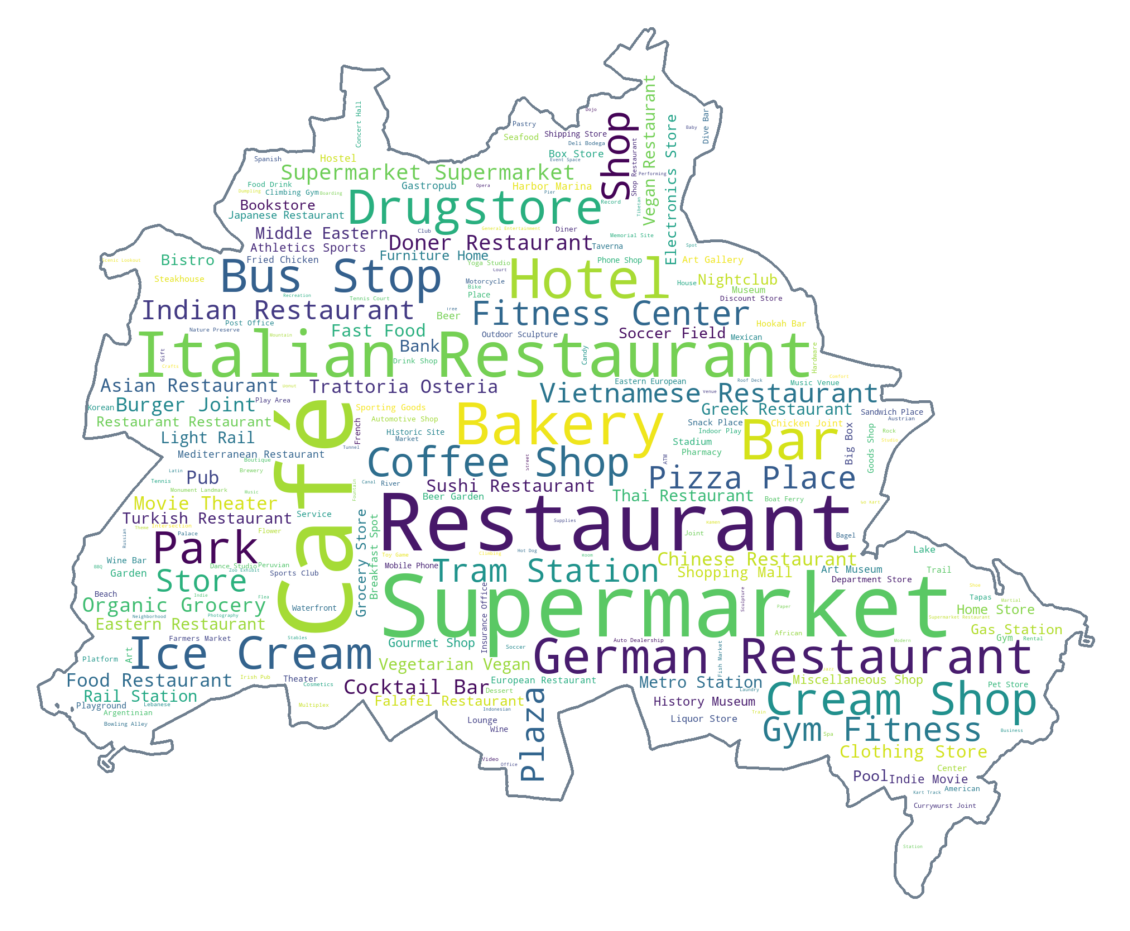

In [21]:
# generate word cloud
wc.generate(text)

# store to file
wc.to_file(path.join(d, "Berlin Wordcloud.png"))

# show
plt.figure(1, [20, 20])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.axis("off")
plt.show()

#### Check Number of Returned Venues in each Neighbourhood

In [22]:
venues_grouped = berlin_venues.groupby('Neighbourhood').count()['Venue'].sort_values()

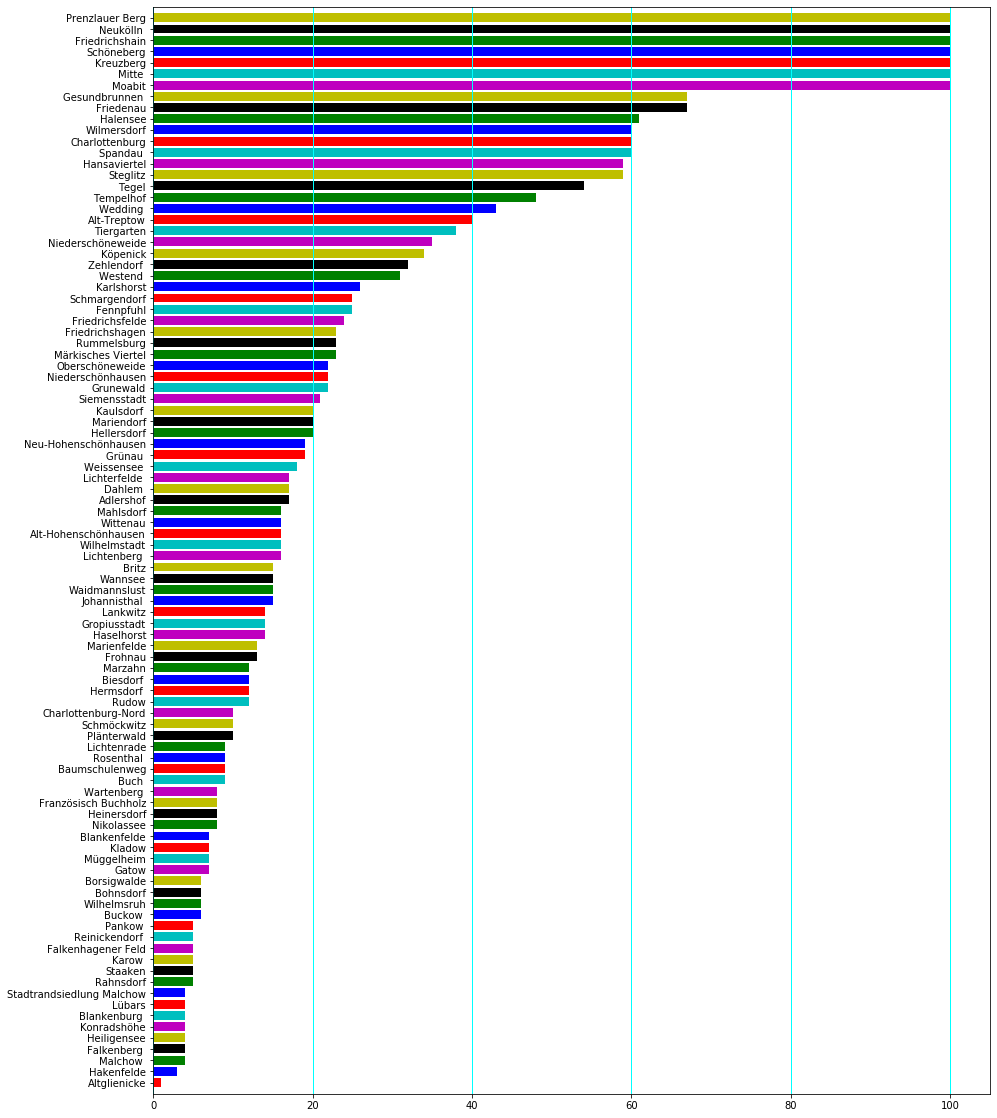

In [23]:
x = venues_grouped.index
y_pos = np.arange(len(x))
plt.figure(1, [15, 20])
plt.barh(x, venues_grouped, color='rbgkymc')
plt.ylim(-1,max(y_pos)+1)
plt.set_cmap('plasma')
plt.grid(lw=1, c='cyan', axis='x')

#plt.savefig("Berlin Neighbourhoods.png")

plt.show()

#### Analyse the Venues in each Neighbourhood

In [24]:
# one hot encoding
berlin_onehot = pd.get_dummies(berlin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
berlin_onehot['Neighbourhood'] = berlin_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [berlin_onehot.columns[-1]] + list(berlin_onehot.columns[:-1])
berlin_onehot = berlin_onehot[fixed_columns]

berlin_onehot.head()

Neighbourhood  ATM  Adult Boutique  African Restaurant  American Restaurant  \
0     Adlershof    0               0                   0                    0   
1     Adlershof    0               0                   0                    0   
2     Adlershof    0               0                   0                    0   
3     Adlershof    0               0                   0                    0   
4     Adlershof    0               0                   0                    0   

   Animal Shelter  Argentinian Restaurant  Art Gallery  Art Museum  \
0               0                       0            0           0   
1               0                       0            0           0   
2               0                       0            0           0   
3               0                       0            0           0   
4               0                       0            0           0   

   Arts & Crafts Store  ...  Water Park  Waterfront  Whisky Bar  Windmill  \
0                    0  ...           0           0           0         0   
1                    0  ...           0           0           0         0   
2                    0  ...           0           0           0         0   
3                    0  ...           0           0           0         0   
4                    0  ...           0           0           0         0   

   Wine Bar  Wine Shop  Winery  Yoga Studio  Zoo  Zoo Exhibit  
0         0          0       0            0    0            0  
1         0          0       0            0    0            0  
2         0          0       0            0    0            0  
3         0          0       0            0    0            0  
4         0          0       0            0    0            0  

[5 rows x 293 columns]

In [25]:
berlin_onehot.shape

(2439, 293)

#### Group by Neighbourhood, Take the Mean of the Frequency each Venue Category

In [26]:
berlin_grouped = berlin_onehot.groupby('Neighbourhood').mean().reset_index()
berlin_grouped

Neighbourhood    ATM  Adult Boutique  African Restaurant  \
0              Adlershof  0.000             0.0                 0.0   
1   Alt-Hohenschönhausen  0.000             0.0                 0.0   
2            Alt-Treptow  0.025             0.0                 0.0   
3           Altglienicke  0.000             0.0                 0.0   
4         Baumschulenweg  0.000             0.0                 0.0   
..                   ...    ...             ...                 ...   
91           Wilhelmsruh  0.000             0.0                 0.0   
92          Wilhelmstadt  0.000             0.0                 0.0   
93           Wilmersdorf  0.000             0.0                 0.0   
94              Wittenau  0.000             0.0                 0.0   
95           Zehlendorf   0.000             0.0                 0.0   

    American Restaurant  Animal Shelter  Argentinian Restaurant  Art Gallery  \
0                   0.0             0.0                0.000000          0.0   
1                   0.0             0.0                0.000000          0.0   
2                   0.0             0.0                0.000000          0.0   
3                   0.0             0.0                0.000000          0.0   
4                   0.0             0.0                0.000000          0.0   
..                  ...             ...                     ...          ...   
91                  0.0             0.0                0.000000          0.0   
92                  0.0             0.0                0.062500          0.0   
93                  0.0             0.0                0.016667          0.0   
94                  0.0             0.0                0.000000          0.0   
95                  0.0             0.0                0.000000          0.0   

    Art Museum  Arts & Crafts Store  ...  Water Park  Waterfront  Whisky Bar  \
0          0.0                  0.0  ...         0.0         0.0         0.0   
1          0.0                  0.0  ...         0.0         0.0         0.0   
2          0.0                  0.0  ...         0.0         0.0         0.0   
3          0.0                  0.0  ...         0.0         0.0         0.0   
4          0.0                  0.0  ...         0.0         0.0         0.0   
..         ...                  ...  ...         ...         ...         ...   
91         0.0                  0.0  ...         0.0         0.0         0.0   
92         0.0                  0.0  ...         0.0         0.0         0.0   
93         0.0                  0.0  ...         0.0         0.0         0.0   
94         0.0                  0.0  ...         0.0         0.0         0.0   
95         0.0                  0.0  ...         0.0         0.0         0.0   

    Windmill  Wine Bar  Wine Shop  Winery  Yoga Studio  Zoo  Zoo Exhibit  
0        0.0       0.0        0.0     0.0      0.00000  0.0          0.0  
1        0.0       0.0        0.0     0.0      0.00000  0.0          0.0  
2        0.0       0.0        0.0     0.0      0.00000  0.0          0.0  
3        0.0       0.0        0.0     0.0      0.00000  0.0          0.0  
4        0.0       0.0        0.0     0.0      0.00000  0.0          0.0  
..       ...       ...        ...     ...          ...  ...          ...  
91       0.0       0.0        0.0     0.0      0.00000  0.0          0.0  
92       0.0       0.0        0.0     0.0      0.00000  0.0          0.0  
93       0.0       0.0        0.0     0.0      0.00000  0.0          0.0  
94       0.0       0.0        0.0     0.0      0.00000  0.0          0.0  
95       0.0       0.0        0.0     0.0      0.03125  0.0          0.0  

[96 rows x 293 columns]

#### Check new Dataframe Size

In [27]:
berlin_grouped.shape

(96, 293)

#### Print each neighborhood along with the top 5 most common venues

In [28]:
num_top_venues = 5

for hood in berlin_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = berlin_grouped[berlin_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adlershof----
               venue  freq
0        Supermarket  0.18
1   Insurance Office  0.06
2           Bus Stop  0.06
3   Greek Restaurant  0.06
4  German Restaurant  0.06


----Alt-Hohenschönhausen----
            venue  freq
0    Tram Station  0.25
1  Discount Store  0.12
2     Coffee Shop  0.06
3           Hotel  0.06
4       Drugstore  0.06


----Alt-Treptow----
       venue  freq
0  Nightclub  0.12
1       Café  0.10
2     Bakery  0.08
3        ATM  0.02
4  Speakeasy  0.02


----Altglienicke----
                venue  freq
0            Bus Stop   1.0
1                 ATM   0.0
2    Pedestrian Plaza   0.0
3  Photography Studio   0.0
4            Pharmacy   0.0


----Baumschulenweg----
                         venue  freq
0                  Supermarket  0.22
1                     Bus Stop  0.11
2                    Drugstore  0.11
3  Eastern European Restaurant  0.11
4                         Café  0.11


----Biesdorf ----
                    venue  freq
0             Super

                venue  freq
0            Bus Stop  0.18
1              Bakery  0.18
2  Italian Restaurant  0.12
3                Pool  0.06
4                Café  0.06


----Lübars----
                     venue  freq
0               Restaurant  0.25
1                  Stables  0.25
2  Comfort Food Restaurant  0.25
3           Ice Cream Shop  0.25
4    Performing Arts Venue  0.00


----Mahlsdorf----
             venue  freq
0     Tram Station  0.12
1      Supermarket  0.12
2  Automotive Shop  0.12
3           Bakery  0.06
4  Motorcycle Shop  0.06


----Malchow ----
               venue  freq
0  German Restaurant  0.25
1    Nature Preserve  0.25
2           Bus Stop  0.25
3               Café  0.25
4                ATM  0.00


----Mariendorf----
              venue  freq
0       Supermarket  0.25
1            Bakery  0.10
2        Steakhouse  0.10
3  Greek Restaurant  0.05
4              Park  0.05


----Marienfelde----
                  venue  freq
0           Supermarket  0.23
1      

#### Write a function to sort the venues in descending order.

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Create the new dataframe and display the top 10 venues for each neighborhood.

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
berlin_neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
berlin_neighbourhoods_venues_sorted['Neighbourhood'] = berlin_grouped['Neighbourhood']

for ind in np.arange(berlin_grouped.shape[0]):
    berlin_neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(berlin_grouped.iloc[ind, :], num_top_venues)

berlin_neighbourhoods_venues_sorted.head()

Neighbourhood 1st Most Common Venue  2nd Most Common Venue  \
0             Adlershof           Supermarket             Steakhouse   
1  Alt-Hohenschönhausen          Tram Station         Discount Store   
2           Alt-Treptow             Nightclub                   Café   
3          Altglienicke              Bus Stop            Zoo Exhibit   
4        Baumschulenweg           Supermarket  Vietnamese Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0          Tram Station             Pet Store     German Restaurant   
1        Ice Cream Shop          Soccer Field           Post Office   
2                Bakery                   ATM      Tapas Restaurant   
3              Fountain           Flea Market           Flower Shop   
4                  Café                Bakery              Bus Stop   

  6th Most Common Venue        7th Most Common Venue 8th Most Common Venue  \
0                  Bank           Athletics & Sports      Greek Restaurant   
1           Supermarket             Greek Restaurant             Drugstore   
2                   Bar                         Park           Beer Garden   
3     Food & Drink Shop                   Food Court      Football Stadium   
4             Drugstore  Eastern European Restaurant      Asian Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0     Trattoria/Osteria               Bus Stop  
1      Asian Restaurant      Indian Restaurant  
2         Big Box Store      Outdoor Sculpture  
3                Forest      French Restaurant  
4            Food Court       Football Stadium

 ### Step 5 - Cluster Berlin Neighbourhoods

In [31]:
# set number of clusters
kclusters = 10

berlin_neighbourhood_grouped_clustering = berlin_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans_berlin = KMeans(n_clusters=kclusters, random_state=0).fit(berlin_neighbourhood_grouped_clustering)

In [32]:
# check cluster labels generated for each row in the dataframe
kmeans_berlin.labels_

array([7, 6, 1, 3, 7, 7, 9, 9, 1, 1, 1, 7, 7, 1, 1, 1, 1, 2, 7, 7, 1, 7,
       1, 1, 1, 4, 1, 1, 1, 7, 8, 1, 1, 7, 5, 6, 1, 2, 7, 1, 2, 7, 2, 2,
       1, 1, 1, 1, 7, 1, 0, 7, 9, 7, 7, 6, 1, 1, 1, 1, 7, 1, 1, 7, 1, 1,
       6, 3, 1, 1, 1, 7, 1, 1, 1, 4, 1, 1, 1, 3, 1, 1, 1, 1, 1, 7, 4, 2,
       1, 7, 1, 7, 7, 1, 1, 1])

##### (Drop existing labels if re-running clustering)

In [33]:
#berlin_neighbourhoods_venues_sorted.drop('Cluster Labels', axis=1, inplace=True)

#### Insert Cluster Labels to Dataframe

In [34]:
# add clustering labels
berlin_neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans_berlin.labels_)

berlin_merged = berlin_df

In [35]:
# merge berlin_grouped with berlin_df to add latitude/longitude for each neighborhood
berlin_merged = berlin_merged.join(berlin_neighbourhoods_venues_sorted.set_index('Neighbourhood'), how='right', on='Neighbourhood')

berlin_merged.head() # check the last columns!

Neighbourhood                                      Full_Location  \
0             Adlershof  (Adlershof, Treptow-Köpenick, Berlin, 12489, D...   
1  Alt-Hohenschönhausen  (Alt-Hohenschönhausen, Lichtenberg, Berlin, De...   
2           Alt-Treptow  (Alt-Treptow, Treptow-Köpenick, Berlin, Deutsc...   
3          Altglienicke  (Altglienicke, Treptow-Köpenick, Berlin, 12524...   
4        Baumschulenweg  (Baumschulenweg, Treptow-Köpenick, Berlin, 124...   

    Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0  52.437893  13.547550               7           Supermarket   
1  52.550409  13.502549               6          Tram Station   
2  52.492563  13.459874               1             Nightclub   
3  52.411838  13.542646               3              Bus Stop   
4  52.461694  13.481548               7           Supermarket   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0             Steakhouse          Tram Station             Pet Store   
1         Discount Store        Ice Cream Shop          Soccer Field   
2                   Café                Bakery                   ATM   
3            Zoo Exhibit              Fountain           Flea Market   
4  Vietnamese Restaurant                  Café                Bakery   

  5th Most Common Venue 6th Most Common Venue        7th Most Common Venue  \
0     German Restaurant                  Bank           Athletics & Sports   
1           Post Office           Supermarket             Greek Restaurant   
2      Tapas Restaurant                   Bar                         Park   
3           Flower Shop     Food & Drink Shop                   Food Court   
4              Bus Stop             Drugstore  Eastern European Restaurant   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0      Greek Restaurant     Trattoria/Osteria               Bus Stop  
1             Drugstore      Asian Restaurant      Indian Restaurant  
2           Beer Garden         Big Box Store      Outdoor Sculpture  
3      Football Stadium                Forest      French Restaurant  
4      Asian Restaurant            Food Court       Football Stadium

#### Display Clusters on Berlin Map

In [36]:
# create map
map_clusters = folium.Map(location=[berlin_latitude, berlin_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(berlin_merged['Latitude'], berlin_merged['Longitude'], berlin_merged['Neighbourhood'], berlin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)   
    
map_clusters

#### Examine Clusters

#### Cluster 1

In [37]:
cluster1 = berlin_merged.loc[berlin_merged['Cluster Labels'] == 0, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]]
cluster1

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
50        Lübars            Restaurant               Stables   

      3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
50  Comfort Food Restaurant        Ice Cream Shop           Zoo Exhibit   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
50      Football Stadium           Fish Market           Flea Market   

   9th Most Common Venue 10th Most Common Venue  
50           Flower Shop      Food & Drink Shop

In [38]:
print('There are {} Neighbourhoods in Cluster 1'.format(cluster1['Neighbourhood'].count()))

There are 1 Neighbourhoods in Cluster 1


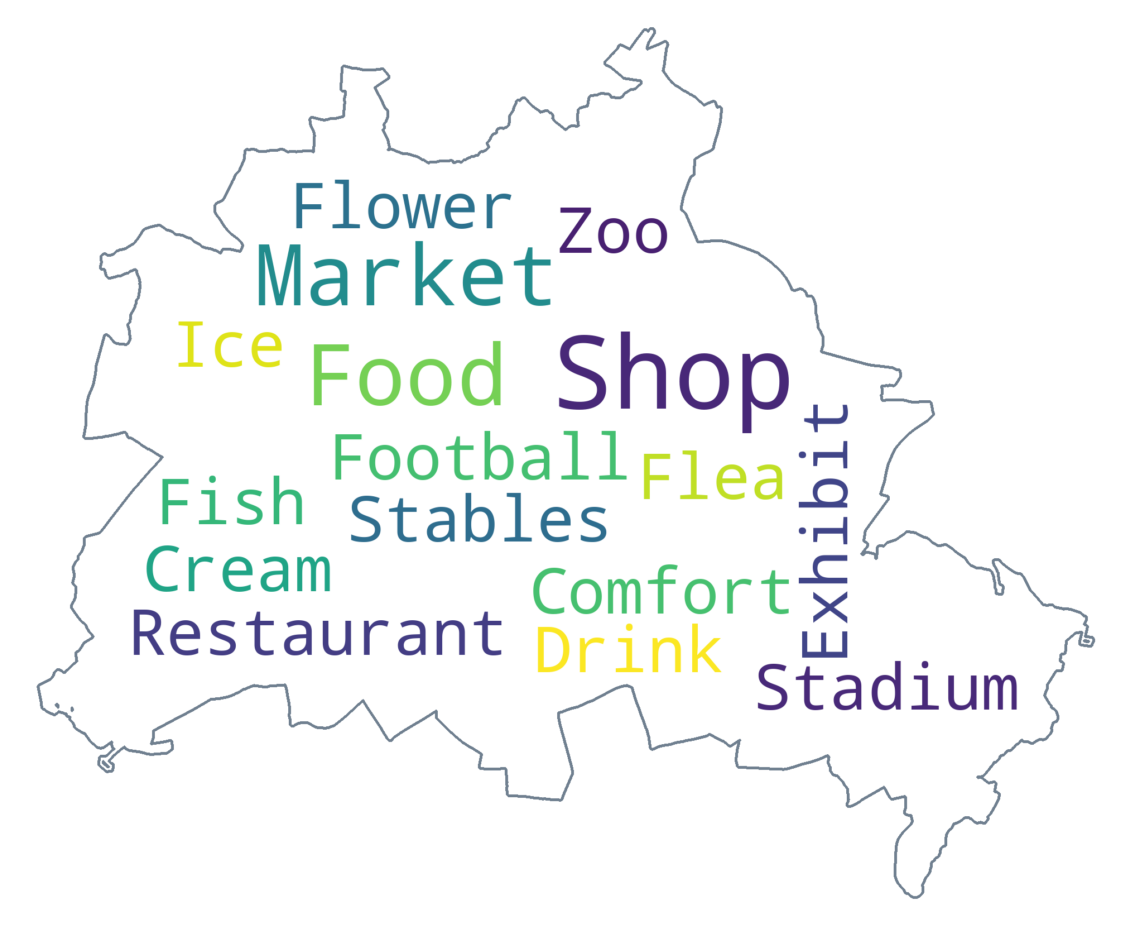

In [39]:
cluster1_text = cluster1.iloc[0:,1:].to_string()
cluster1_text = cluster1_text[255:]

# generate word cloud
wc.generate(cluster1_text)

# show
plt.figure(1, [20, 20])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.axis("off")
plt.show()

#### Cluster 2

In [40]:
cluster2 = berlin_merged.loc[berlin_merged['Cluster Labels'] == 1, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]]
cluster2

Neighbourhood   1st Most Common Venue  \
2                 Alt-Treptow               Nightclub   
8                   Bohnsdorf            Home Service   
9                 Borsigwalde         Motorcycle Shop   
10                      Britz           Metro Station   
13             Charlottenburg             Supermarket   
14        Charlottenburg-Nord                Building   
15                    Dahlem        German Restaurant   
16                Falkenberg           Animal Shelter   
20                  Friedenau                    Café   
22            Friedrichshagen         Organic Grocery   
23             Friedrichshain                    Café   
24                    Frohnau             Supermarket   
26             Gesundbrunnen                     Café   
27               Gropiusstadt           Metro Station   
29                  Grunewald       German Restaurant   
31                   Halensee                   Plaza   
32               Hansaviertel                  Bakery   
36                Hellersdorf           Metro Station   
39                 Karlshorst             Supermarket   
44                   Köpenick          Soccer Stadium   
45                  Kreuzberg                     Bar   
46                   Lankwitz                  Bakery   
47               Lichtenberg   Furniture / Home Store   
49              Lichterfelde                 Bus Stop   
55         Märkisches Viertel      Italian Restaurant   
57                     Mitte                    Hotel   
58                     Moabit    Gym / Fitness Center   
59                 Müggelheim                     Gym   
61                  Neukölln                      Bar   
62          Niederschöneweide             Supermarket   
64                 Nikolassee                   Trail   
65            Oberschöneweide             Supermarket   
68            Prenzlauer Berg                    Café   
69                  Rahnsdorf       Indian Restaurant   
70             Reinickendorf                Gastropub   
72                      Rudow          Ice Cream Shop   
73                Rummelsburg                    Café   
74              Schmargendorf                     Gym   
76                 Schöneberg      Italian Restaurant   
77               Siemensstadt           Metro Station   
78                   Spandau           Clothing Store   
80  Stadtrandsiedlung Malchow              Restaurant   
81                   Steglitz        Sushi Restaurant   
82                      Tegel                    Café   
83                  Tempelhof             Supermarket   
84                 Tiergarten                   Hotel   
88                   Wedding                     Café   
90                   Westend                     Café   
93                Wilmersdorf                  Bakery   
94                   Wittenau                    Park   
95                Zehlendorf                     Café   

          2nd Most Common Venue          3rd Most Common Venue  \
2                          Café                         Bakery   
8            Italian Restaurant               Insurance Office   
9          Fast Food Restaurant             Athletics & Sports   
10  Eastern European Restaurant              German Restaurant   
13                         Café             Chinese Restaurant   
14           Rock Climbing Spot                  Metro Station   
15                       Museum                           Café   
16                  Coffee Shop                       Mountain   
20                  Supermarket             Italian Restaurant   
22                         Café                 Ice Cream Shop   
23                  Coffee Shop  Vegetarian / Vegan Restaurant   
24           Italian Restaurant                            Bar   
26                          Bar                      Drugstore   
27                  Supermarket                          Trail   
29           Italian Restaurant                           Lak

In [41]:
print('There are {} Neighbourhoods in Cluster 2'.format(cluster2['Neighbourhood'].count()))

There are 51 Neighbourhoods in Cluster 2


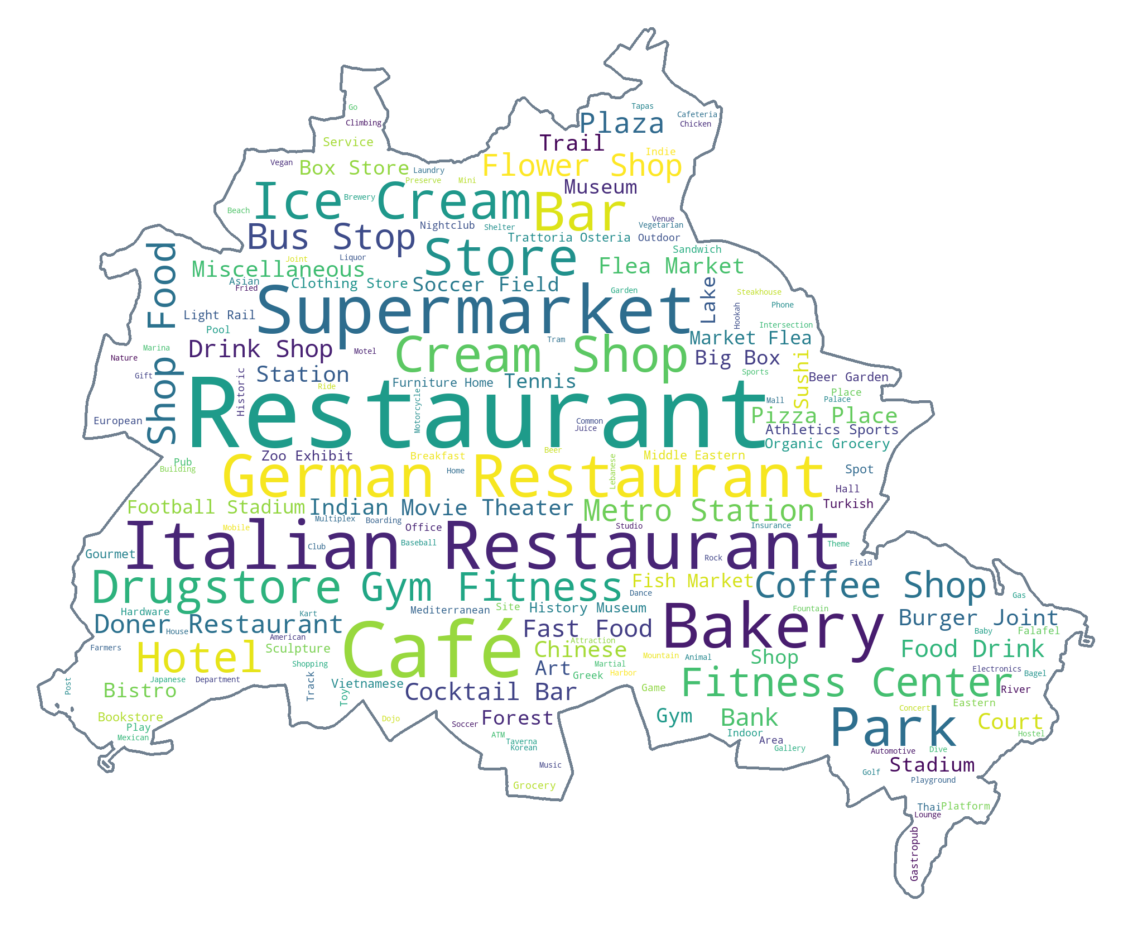

In [42]:
cluster2_text = cluster2.iloc[0:,1:].to_string()
cluster2_text = cluster2_text[255:]

# generate word cloud
wc.generate(cluster2_text)

# show
plt.figure(1, [20, 20])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.axis("off")
plt.show()

#### Cluster 3

In [43]:
cluster3 = berlin_merged.loc[berlin_merged['Cluster Labels'] == 2, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]]
cluster3

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
17  Falkenhagener Feld           Supermarket             Drugstore   
37          Hermsdorf            Supermarket    Italian Restaurant   
40              Karow            Supermarket        Mattress Store   
42              Kladow           Supermarket              Pharmacy   
43         Konradshöhe           Supermarket                 Diner   
87         Wartenberg            Supermarket  Gym / Fitness Center   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
17           Snack Place          Soccer Field           Zoo Exhibit   
37                Bakery             Drugstore       Organic Grocery   
40    Italian Restaurant     German Restaurant           Zoo Exhibit   
42       Organic Grocery              Bus Stop          Liquor Store   
43              Bus Stop              Fountain           Flea Market   
87      Business Service           Pizza Place          Soccer Field   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
17           Flea Market           Flower Shop     Food & Drink Shop   
37      Sushi Restaurant                  Lake             Wine Shop   
40                Forest           Flea Market           Flower Shop   
42                  Pier            Food Court           Fish Market   
43           Flower Shop     Food & Drink Shop            Food Court   
87           Zoo Exhibit            Food Court           Flea Market   

   9th Most Common Venue 10th Most Common Venue  
17            Food Court       Football Stadium  
37    Seafood Restaurant     Frozen Yogurt Shop  
40     Food & Drink Shop             Food Court  
42           Flea Market            Flower Shop  
43      Football Stadium                 Forest  
87           Flower Shop      Food & Drink Shop

In [44]:
print('There are {} Neighbourhoods in Cluster 3'.format(cluster3['Neighbourhood'].count()))

There are 6 Neighbourhoods in Cluster 3


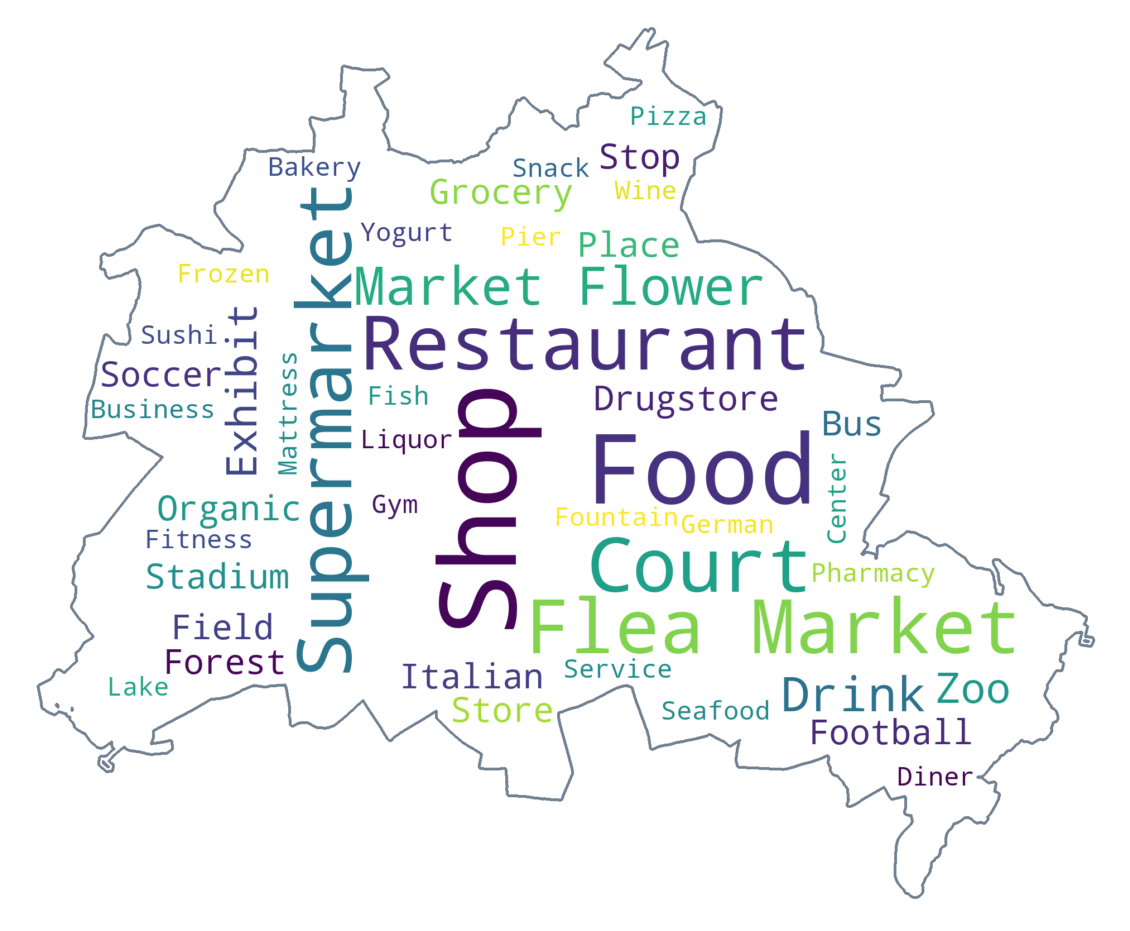

In [45]:
cluster3_text = cluster3.iloc[0:,1:].to_string()
cluster3_text = cluster3_text[255:]

# generate word cloud
wc.generate(cluster3_text)

# show
plt.figure(1, [20, 20])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.axis("off")
plt.show()

#### Cluster 4

In [46]:
cluster4 = berlin_merged.loc[berlin_merged['Cluster Labels'] == 3, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]]
cluster4

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
3   Altglienicke              Bus Stop           Zoo Exhibit   
67   Plänterwald              Bus Stop            Playground   
79       Staaken              Bus Stop            Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
3               Fountain           Flea Market           Flower Shop   
67           Supermarket          Liquor Store                  Lake   
79    Italian Restaurant           Zoo Exhibit                Forest   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
3      Food & Drink Shop            Food Court      Football Stadium   
67    Light Rail Station           Zoo Exhibit      Football Stadium   
79           Fish Market           Flea Market           Flower Shop   

   9th Most Common Venue 10th Most Common Venue  
3                 Forest      French Restaurant  
67           Flea Market            Flower Shop  
79     Food & Drink Shop             Food Court

In [47]:
print('There are {} Neighbourhoods in Cluster 4'.format(cluster4['Neighbourhood'].count()))

There are 3 Neighbourhoods in Cluster 4


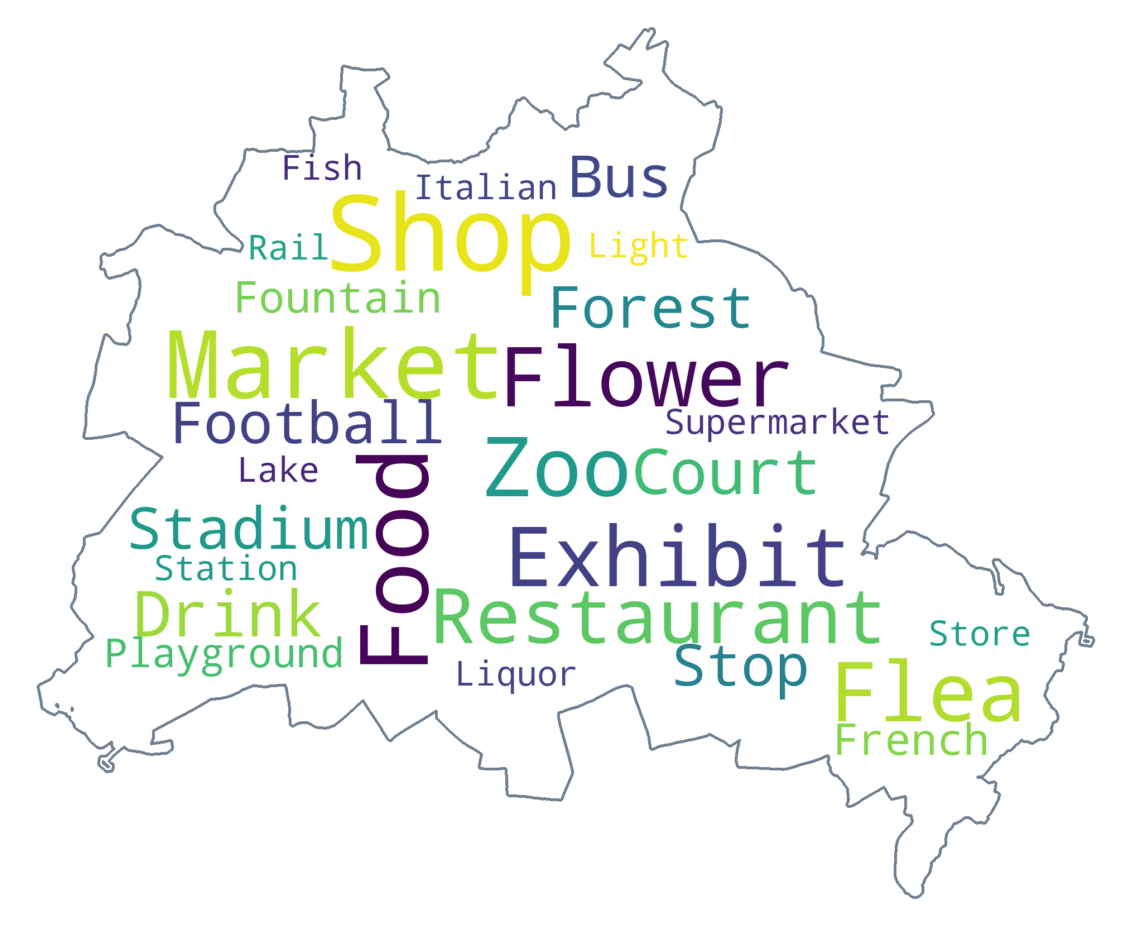

In [48]:
cluster4_text = cluster4.iloc[0:,1:].to_string()
cluster4_text = cluster4_text[255:]

# generate word cloud
wc.generate(cluster4_text)

# show
plt.figure(1, [20, 20])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.axis("off")
plt.show()

#### Cluster 5

In [49]:
cluster5 = berlin_merged.loc[berlin_merged['Cluster Labels'] == 4, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]]
cluster5

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
25         Gatow        Farmers Market    Italian Restaurant   
75   Schmöckwitz       Harbor / Marina           Supermarket   
86       Wannsee       Harbor / Marina           Supermarket   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
25           Supermarket       Harbor / Marina              Bus Stop   
75    Miscellaneous Shop          Tram Station                 Hotel   
86   Austrian Restaurant           Post Office    Chinese Restaurant   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
25     Trattoria/Osteria                 Hotel            Food Court   
75     German Restaurant        Ice Cream Shop           Gas Station   
86                  Bank                Bakery                  Lake   

   9th Most Common Venue 10th Most Common Venue  
25           Fish Market            Flea Market  
75    Italian Restaurant      French Restaurant  
86     Indian Restaurant           Liquor Store

In [50]:
print('There are {} Neighbourhoods in Cluster 5'.format(cluster5['Neighbourhood'].count()))

There are 3 Neighbourhoods in Cluster 5


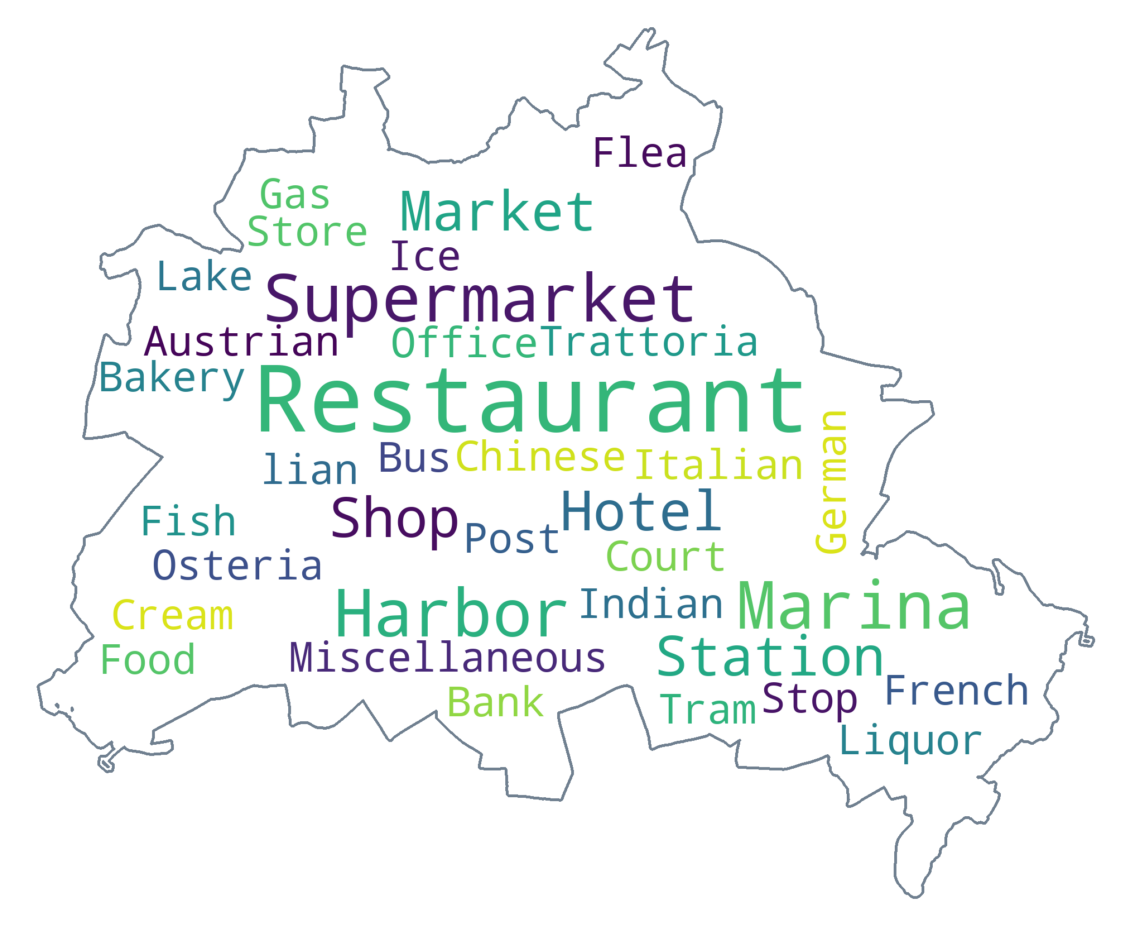

In [51]:
cluster5_text = cluster5.iloc[0:,1:].to_string()
cluster5_text = cluster5_text[255:]

# generate word cloud
wc.generate(cluster5_text)

# show
plt.figure(1, [20, 20])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.axis("off")
plt.show()

#### Cluster 6

In [52]:
cluster6 = berlin_merged.loc[berlin_merged['Cluster Labels'] == 5, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]]
cluster6

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
34   Heiligensee      Insurance Office    Photography Studio   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
34                Forest  Fast Food Restaurant           Fish Market   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
34           Flea Market           Flower Shop     Food & Drink Shop   

   9th Most Common Venue 10th Most Common Venue  
34            Food Court       Football Stadium

In [53]:
print('There are {} Neighbourhoods in Cluster 6'.format(cluster6['Neighbourhood'].count()))

There are 1 Neighbourhoods in Cluster 6


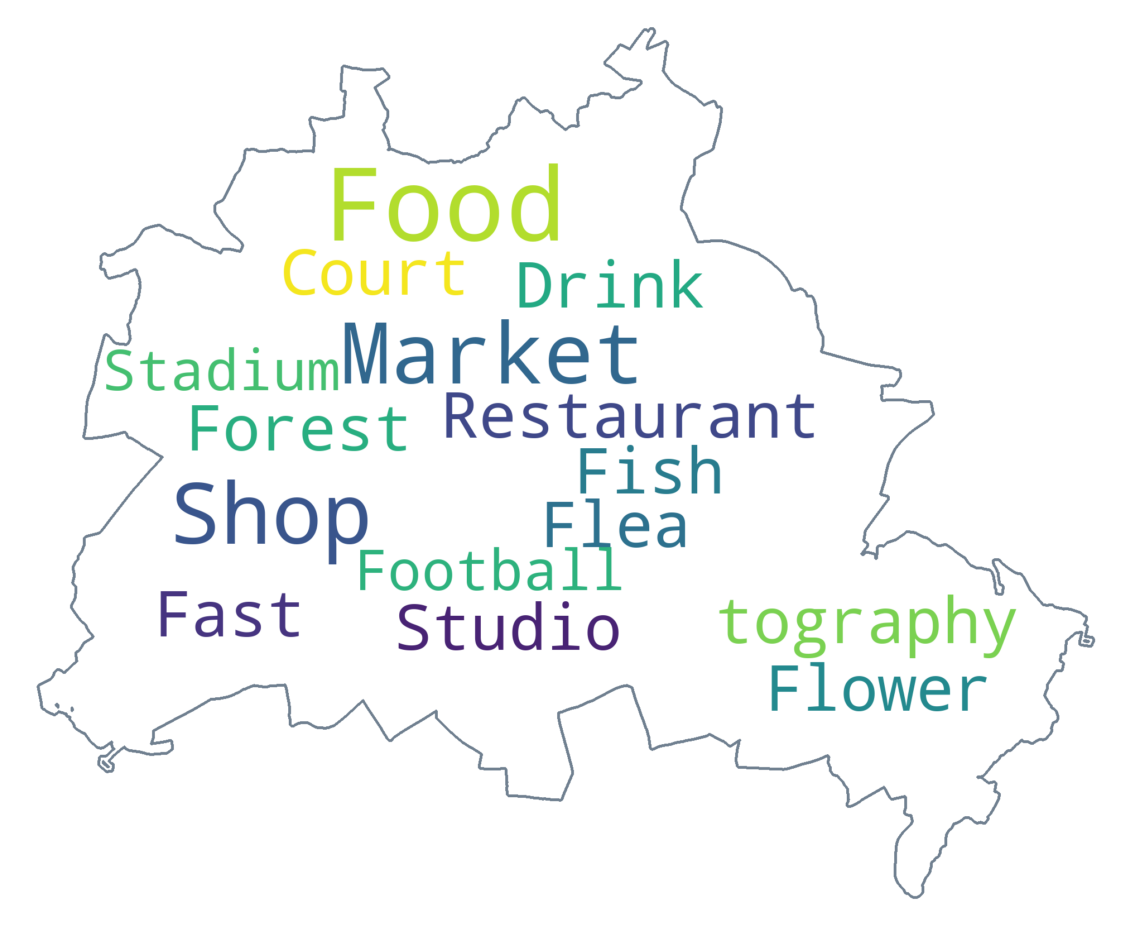

In [54]:
cluster6_text = cluster6.iloc[0:,1:].to_string()
cluster6_text = cluster6_text[255:]

# generate word cloud
wc.generate(cluster6_text)

# show
plt.figure(1, [20, 20])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.axis("off")
plt.show()

#### Cluster 7

In [55]:
cluster7 = berlin_merged.loc[berlin_merged['Cluster Labels'] == 6, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]]
cluster7

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
1   Alt-Hohenschönhausen          Tram Station        Discount Store   
35           Heinersdorf          Tram Station        Discount Store   
56               Marzahn          Tram Station                 Plaza   
66               Pankow           Tram Station           Supermarket   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
1         Ice Cream Shop          Soccer Field           Post Office   
35    Chinese Restaurant           Supermarket           Fish Market   
56    Italian Restaurant              Bus Stop              Windmill   
66      Asian Restaurant              Fountain           Flea Market   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
1            Supermarket      Greek Restaurant             Drugstore   
35   Fried Chicken Joint      Football Stadium           Flea Market   
56       Cultural Center     German Restaurant      Asian Restaurant   
66           Flower Shop     Food & Drink Shop            Food Court   

   9th Most Common Venue 10th Most Common Venue  
1       Asian Restaurant      Indian Restaurant  
35           Flower Shop      Food & Drink Shop  
56        Ice Cream Shop       Football Stadium  
66      Football Stadium                 Forest

In [56]:
print('There are {} Neighbourhoods in Cluster 7'.format(cluster7['Neighbourhood'].count()))

There are 4 Neighbourhoods in Cluster 7


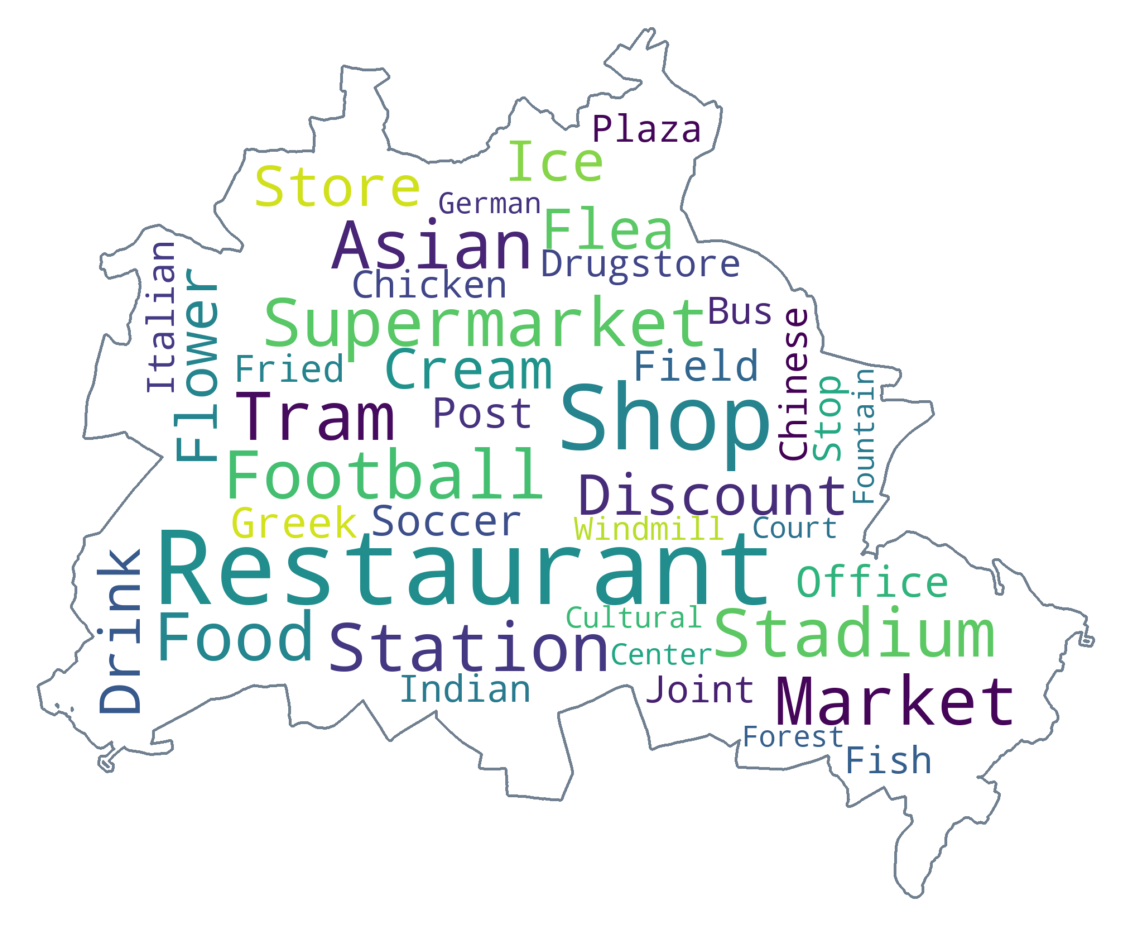

In [57]:
cluster7_text = cluster7.iloc[0:,1:].to_string()
cluster7_text = cluster7_text[255:]

# generate word cloud
wc.generate(cluster7_text)

# show
plt.figure(1, [20, 20])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.axis("off")
plt.show()

#### Cluster 8

In [58]:
cluster8 = berlin_merged.loc[berlin_merged['Cluster Labels'] == 7, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]]
cluster8

Neighbourhood 1st Most Common Venue  2nd Most Common Venue  \
0              Adlershof           Supermarket             Steakhouse   
4         Baumschulenweg           Supermarket  Vietnamese Restaurant   
5              Biesdorf            Supermarket     Athletics & Sports   
11                 Buch     Light Rail Station               Bus Stop   
12               Buckow            Supermarket      Indian Restaurant   
18             Fennpfuhl           Supermarket              Drugstore   
19  Französisch Buchholz           Supermarket              Rest Area   
21       Friedrichsfelde           Supermarket              Drugstore   
28               Grünau            Supermarket                  Hotel   
33            Haselhorst           Supermarket               Bus Stop   
38         Johannisthal            Supermarket          Movie Theater   
41            Kaulsdorf            Supermarket                  Hotel   
48           Lichtenrade           Supermarket           Soccer Field   
51             Mahlsdorf          Tram Station        Automotive Shop   
53            Mariendorf           Supermarket             Steakhouse   
54           Marienfelde           Supermarket         Farmers Market   
60  Neu-Hohenschönhausen           Supermarket   Fast Food Restaurant   
63     Niederschönhausen           Supermarket     Italian Restaurant   
71            Rosenthal           Tram Station            Supermarket   
85         Waidmannslust           Supermarket     Italian Restaurant   
89           Weissensee            Supermarket      German Restaurant   
91           Wilhelmsruh           Music Venue               Pharmacy   
92          Wilhelmstadt              Bus Stop            Supermarket   

   3rd Most Common Venue   4th Most Common Venue 5th Most Common Venue  \
0           Tram Station               Pet Store     German Restaurant   
4                   Café                  Bakery              Bus Stop   
5                 Palace  Furniture / Home Store              Pharmacy   
11    Italian Restaurant             Supermarket           Art Gallery   
12        Discount Store       German Restaurant  Fast Food Restaurant   
18          Tram Station            Soccer Field      Department Store   
19           Flower Shop            Tram Station        Hardware Store   
21           Zoo Exhibit               Gastropub                   Zoo   
28          Tram Station      Light Rail Station     Electronics Store   
33     Electronics Store              Beer Store    Miscellaneous Shop   
38                 Hotel            Burger Joint                   Pub   
41    Light Rail Station                     ATM             Pet Store   
48      Department Store              Restaurant     German Restaurant   
51           Supermarket        Greek Restaurant    Athletics & Sports   
53                Bakery            Climbing Gym        Ice Cream Shop   
54          Tennis Court      Chinese Restaurant                Bakery   
60     Electronics Store                Bus Stop             Bookstore   
63       Thai Restaurant            Dessert Shop                  Park   
71     German Restaurant         Automotive Shop                 Hotel   
85  Gym / Fitness Center           Shopping Mall  Fast Food Restaurant   
89                 Diner                   Hotel              Bus Stop   
91            Restaurant             Supermarket    Mexican Restaurant   
92         Boat or Ferry         Harbor / Marina             Gastropub   

     6th Most Common Venue        7th Most Common Venue  \
0                     Bank           Athletics & Sports   
4                Drugstore  Eastern European Restaurant   
5                    Plaza                    Drugstore   
11               Drugstore                Big Box Store   
12             Flea Market                  Flower Shop   
18                    Park               Shipping Store   
19               Drugstore                Garden Center   
21       

In [59]:
print('There are {} Neighbourhoods in Cluster 8'.format(cluster8['Neighbourhood'].count()))

There are 23 Neighbourhoods in Cluster 8


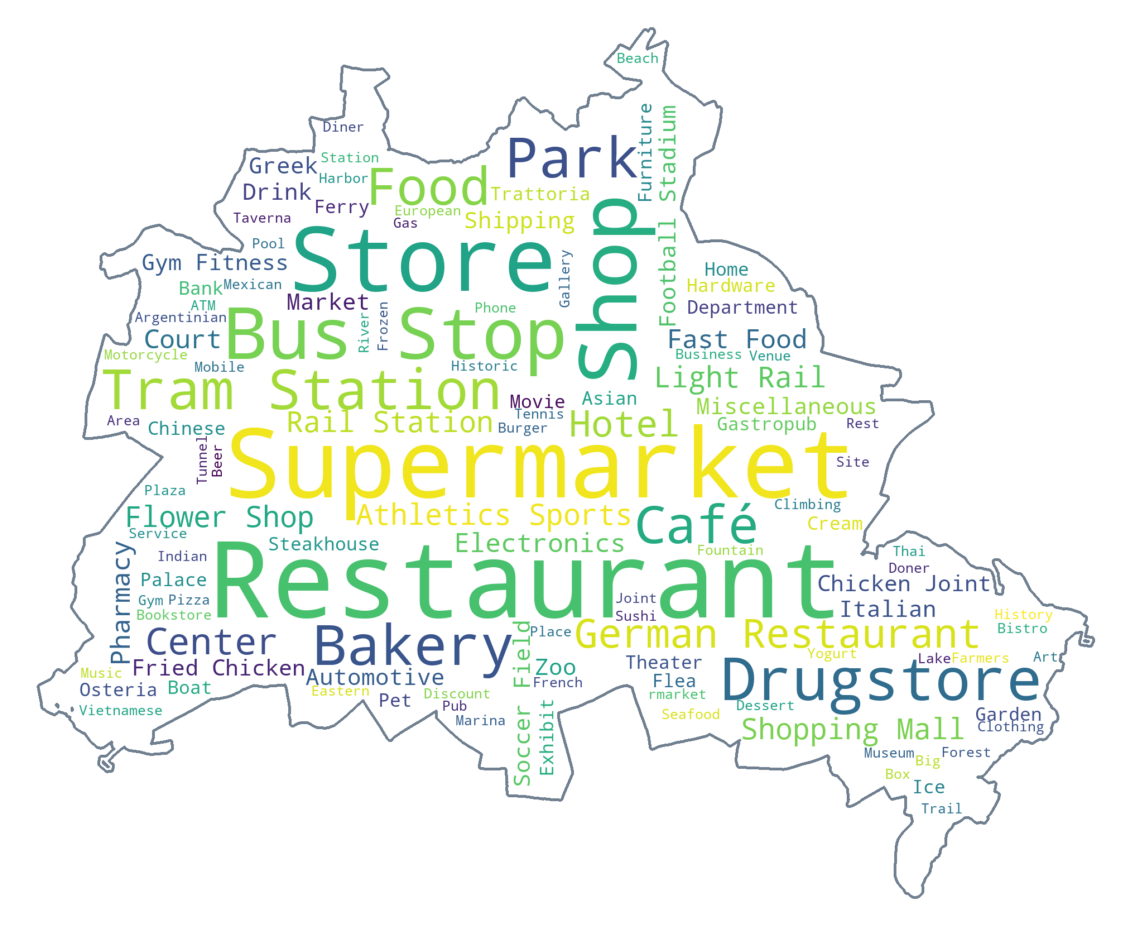

In [60]:
cluster8_text = cluster8.iloc[0:,1:].to_string()
cluster8_text = cluster8_text[255:]

# generate word cloud
wc.generate(cluster8_text)

# show
plt.figure(1, [20, 20])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.axis("off")
plt.show()

#### Cluster 9

In [61]:
cluster9 = berlin_merged.loc[berlin_merged['Cluster Labels'] == 8, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]]
cluster9

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
30    Hakenfelde     German Restaurant              Bus Stop   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
30                  Pool           Zoo Exhibit              Fountain   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
30           Flea Market           Flower Shop     Food & Drink Shop   

   9th Most Common Venue 10th Most Common Venue  
30            Food Court       Football Stadium

In [62]:
print('There are {} Neighbourhoods in Cluster 9'.format(cluster9['Neighbourhood'].count()))

There are 1 Neighbourhoods in Cluster 9


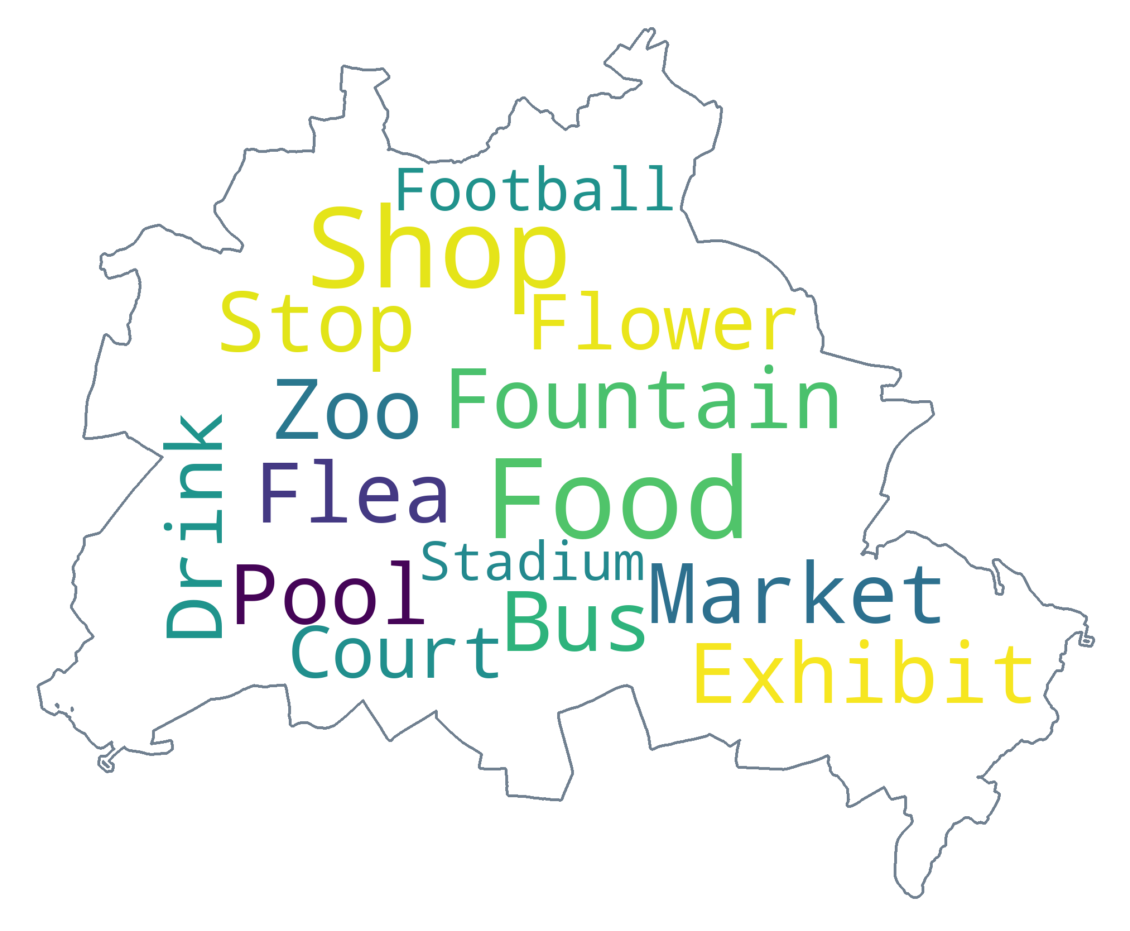

In [63]:
cluster9_text = cluster9.iloc[0:,1:].to_string()
cluster9_text = cluster9_text[255:]

# generate word cloud
wc.generate(cluster9_text)

# show
plt.figure(1, [20, 20])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.axis("off")
plt.show()

#### Cluster 10

In [64]:
cluster10 = berlin_merged.loc[berlin_merged['Cluster Labels'] == 9, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]]
cluster10

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
6   Blankenburg                 Bakery              Bus Stop   
7   Blankenfelde                  Café        Clothing Store   
52      Malchow                   Café       Nature Preserve   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
6       Greek Restaurant                  Café     French Restaurant   
7                Stables              Bus Stop    Miscellaneous Shop   
52     German Restaurant              Bus Stop           Zoo Exhibit   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
6            Flower Shop     Food & Drink Shop            Food Court   
7            Zoo Exhibit              Fountain     Food & Drink Shop   
52           Flower Shop     Food & Drink Shop            Food Court   

   9th Most Common Venue 10th Most Common Venue  
6       Football Stadium                 Forest  
7             Food Court       Football Stadium  
52      Football Stadium                 Forest

In [65]:
print('There are {} Neighbourhoods in Cluster 10'.format(cluster10['Neighbourhood'].count()))

There are 3 Neighbourhoods in Cluster 10


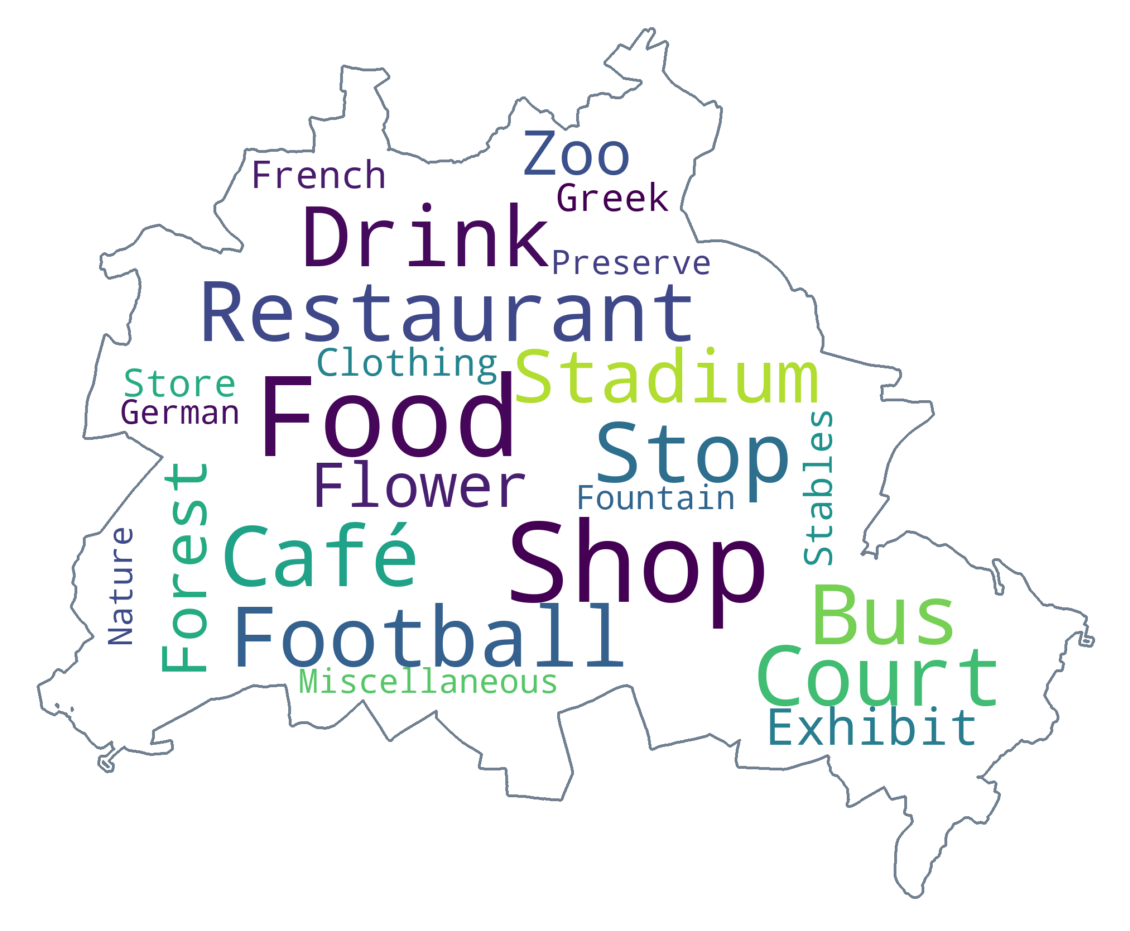

In [66]:
cluster10_text = cluster10.iloc[0:,1:].to_string()
cluster10_text = cluster10_text[255:]

# generate word cloud
wc.generate(cluster10_text)

# show
plt.figure(1, [20, 20])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.axis("off")
plt.show()